<a href="https://colab.research.google.com/github/shamim-hussain/tic_tac_toe_q_learning/blob/master/tic_tac_toe_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to play Tic-Tac-Toe using Q learning

## The Game Class and the Player Class
First we will define a game class which can simulate a tic-tac-toe game and an **abstract** player class which can simulate a player. We will assume that the palyer 1, who makes the first move, has a signature "X", whereas the palyer 2 has a signature "O".

The game objects will keep track of the state of the game, the available moves, and alos the sequence of states and moves, which will allow us to train the Q-learner more easily. This object will also be able to render the game's state as graphical represenations for easy visualization.

The player object is required to take a move given the game's state and available moves.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


class Game:
    def __init__(self, player_x, player_o):
        self.player_x = player_x
        self.player_o = player_o
        self.state = (0,)*9
        self.available = list(range(9))
        self.state_sequence = [self.state]
        self.move_sequence = []
        self._init_graphics = False
    
    def init_graphics(self):
        self._init_graphics = True
        
        m = 10

        cross = np.zeros([5*m,5*m],dtype=np.float32)
        cross = cv2.line(cross, (1*m,1*m), (4*m,4*m), 1, (4*m)//5, cv2.LINE_AA)
        cross = cv2.line(cross, (4*m,1*m), (1*m,4*m), 1, (4*m)//5, cv2.LINE_AA)

        circle = np.zeros([5*m,5*m],dtype=np.float32)
        circle = cv2.circle(circle, ((5*m)//2,(5*m)//2), (3*m)//2, 1, (4*m)//5)

        board = np.zeros([17*m,17*m])
        board = cv2.line(board, ((11*m)//2, m//5), ((11*m)//2, 17*m-m//5), 
                                                      1, (4*m//5), cv2.LINE_AA)
        board = cv2.line(board, (m//5, (11*m)//2), (17*m-m//5, (11*m)//2), 
                                                      1, (4*m//5), cv2.LINE_AA)
        board = cv2.line(board, ((23*m)//2, m//5), ((23*m)//2, 17*m-m//5), 
                                                      1, (4*m//5), cv2.LINE_AA)
        board = cv2.line(board, (m//5, (23*m)//2), (17*m-m//5, (23*m)//2), 
                                                      1, (4*m//5), cv2.LINE_AA)

        self.cross = cross
        self.circle = circle
        self.board = board
        self.board_posistions = [[  0,  0], [  0, 60], [  0,120], 
                                 [ 60,  0], [ 60, 60], [ 60,120], 
                                 [120,  0], [120, 60], [120,120]]
    
    def render_state(self, state=None):
        if not self._init_graphics:
            self.init_graphics()
        
        if state is None:
            state = self.state
        
        board = self.board.copy()
        for k in range(9):
            if state[k]==0:
                continue
            elif state[k]>0:
                img = self.cross
            elif state[k]<0:
                img = self.circle

            start_x,start_y = self.board_posistions[k]
            end_x,end_y=start_x+img.shape[0], start_y+img.shape[1]
            board[start_x:end_x,start_y:end_y]=img
        
        return board
    
    def check_win(self):
        for i in range(3):
            if self.state[i]==self.state[i+3]==self.state[i+6]:
                return self.state[i]
            
            ss = i*3
            if self.state[ss]==self.state[ss+1]==self.state[ss+2]:
                return self.state[ss]

        if self.state[0]==self.state[4]==self.state[8]:
            return self.state[0]
        if self.state[2]==self.state[4]==self.state[6]:
            return self.state[2]
        return 0
    
    def play(self):
        while True:
            move = self.player_x.next_move(self)
            self.move_sequence.append(move)
            self.state = tuple((1 if i==move else self.state[i]) for i in range(9))
            self.available.remove(move)
            self.state_sequence.append(self.state)
            win_val = self.check_win()
            yield win_val
            if win_val:
                self.result = win_val
                return
            
            if not len(self.available):
                self.result = 0
                return
            
            move = self.player_o.next_move(self)
            self.move_sequence.append(move)
            self.state = tuple((-1 if i==move else self.state[i]) for i in range(9))
            self.available.remove(move)
            self.state_sequence.append(self.state)
            win_val = self.check_win()
            yield win_val
            if win_val:
                self.result = win_val
                return



class Player:
    def __init__(self, name):
        self.name = name
    
    def next_move(self, game):
        raise NotImplementedError



Next we will subclass the Player class to design our Q learning player. 
* The state-action values, or the Q values will be stored in a lookup table, which will be a dictionary of dictionaries. 
* Given any game state the Q player epsilon-greedily chooses the best next move from set of available moves, based on the learned Q values.
* Since Q-learning is an off policy learning technique, we do not need to worry about the policy that generates the data. But we need to ensure that the algorithm makes enough exploration. Since there are not many game configurations for tic-tac-toe, a moderate to large epsilon value will be enough to visit all configurations and actions.
* There will be a discount factor gamma, but its value would not really matter much, because all tic-tac-toe games end in less than 10 moves.
* We will assume a reward of +1 for win, -1 for lose and 0 for draw. There is only a single reward at the end of the game.
* We can design 2 Q-learners and pit them agaist each other, but that will complicate the learning process because the other player becomes a part of the first palyer's environment. Q-learning is agnostic to policies, but not to changing environment.
    * An easy solution is to notice that the game states of 2 players come in turns, and the Q-values of one player is actually the negative of the other player. So, during the bootstrapping update (the bellman optimality equation) we can just take the negative of the max of the Q values of the next state and that would produce the correction that we need to make.
* We perform the bootstrapped updates starting from the last state action pair and going backword. So, this is an offline learning scheme, since the player only learns at the end of the game. But this would allow us to make more effective updates because there is only one reward at the end of the game and the signal from this reward propagates backwards towards the decisions made to reach that reward.
* We will use a learning rate of alpha to make corrections to the Q-values.

In [24]:
from collections import defaultdict
import random
import numpy as np

class QPlayer(Player):
    def __init__(self, epsilon=0., gamma=0.999, alpha=0.1, name='QPlayer'):
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.name = name
        
        self.Q = defaultdict(lambda: defaultdict(float))
    
    def next_move(self, game):
        if random.uniform(0,1)<self.epsilon:
            move = random.choice(game.available)
        else:
            available = game.available
            random.shuffle(available)
            move = max(available, key=lambda x: self.Q[game.state][x])
        return move
    
    def backup_update(self, game):
        if game.result==0:
            return 0.
        elif game.result>0:
            reward = game.result
        else:
            reward = -game.result
        
        errors = []

        state = game.state_sequence[-2]
        move = game.move_sequence[-1]

        error = (reward - self.Q[state][move])
        self.Q[state][move] += self.alpha*error
        errors.append(np.abs(error))
        
        for t in reversed(range(len(game.move_sequence)-1)):
            state = game.state_sequence[t]
            move = game.move_sequence[t]
            next_state = game.state_sequence[t+1]
            
            error = -self.gamma*max(self.Q[next_state].values()) - self.Q[state][move]
            self.Q[state][move] += self.alpha*error
            errors.append(np.abs(error))

        return np.mean(errors)
        
        

## Training the QPlayer

Now we will simulate games between two q-palyers. Heuriscially, the Q-learner takes aroun 200000 games with epsilon=0.9 to fully learn the Q values. But we will train it for 1 Million games.

In [26]:
from tqdm import trange

num_games = 1000000

q_player_1 = QPlayer(epsilon=0.9, gamma=.999, alpha=0.1, name='q-player-1')

running_mae_sum = 0.
tr = trange(num_games)
try:
    for i in tr:
        game = Game(q_player_1, q_player_1)
        for _ in game.play():
            pass
        running_mae_sum += q_player_1.backup_update(game)
        if not (i+1)%100:
            mae = running_mae_sum/(i+1)
            tr.set_description(f'Mean absolute error = {mae:0.5f}')
finally:
    tr.close()

Mean absolute error = 0.01770: 100%|██████████| 1000000/1000000 [02:30<00:00, 6656.67it/s]


# Games between perfect QPalyers

A game between two perfect Q players is likely to lead to always lead to a draw. Let us verify this.

In [50]:
import matplotlib.pyplot as plt
def machine_move_to_human_move(move):
    i = move//3 + 1
    j = move%3 + 1
    return f'{i}{j}'

def human_move_to_machine_move(move):
    i,j = move
    i,j = int(i)-1, int(j)-1
    return i*3+j

def view_game(game):
    plt.imshow(game.render_state(),cmap='gray')
    plt.axis('off')
    plt.show()
    plt.pause(0.1)


def player_vs_player(player_1, player_2):
    game = Game(player_1, player_2)
    q = dict((machine_move_to_human_move(move),f'{val:.3f}') 
                for move, val in Q_values[game.state].items())
    print('Game Starts!!')
    view_game(game)
    for i,_ in enumerate(game.play()):
        print()
        print(f"Action values:", '; '.join('=>'.join(kv) 
                for kv in sorted(q.items(),key=lambda kv:kv[1])))
        move = machine_move_to_human_move(game.move_sequence[-1])
        if not i%2:
            print(f"{player_1.name}'s move:", move)
        else:
            print(f"{player_2.name}'s move:", move)
        view_game(game)
        q = dict((machine_move_to_human_move(move),f'{val:.3f}') 
                for move, val in Q_values[game.state].items())

    if game.result > 0:
        print(f"{player_1.name} wins!")
    elif game.result < 0:
        print(f"{player_2.name} wins!")
    else:
        print("Draw!")
    


### The players

In [51]:
q_player_1.epsilon = 0.
Q_values = q_player_1.Q

q_player_2 = QPlayer(epsilon=0., gamma=0.999, alpha=0.1, name='q-player-2')
q_player_2.Q = Q_values


### Visualizing the game

Game Starts!!


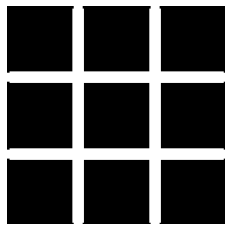


Action values: 12=>0.000; 33=>0.000; 11=>0.000; 32=>0.000; 23=>0.000; 21=>0.000; 13=>0.000; 22=>0.000; 31=>0.000
q-player-1's move: 22


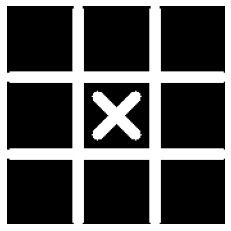


Action values: 31=>-0.000; 11=>-0.000; 13=>-0.000; 33=>-0.000; 32=>-0.995; 12=>-0.995; 21=>-0.995; 23=>-0.995
q-player-2's move: 11


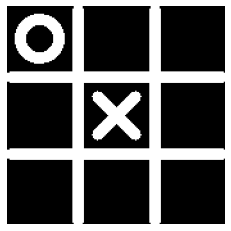


Action values: 32=>-0.000; 21=>0.000; 31=>0.000; 23=>0.000; 12=>0.000; 13=>0.000; 33=>0.000
q-player-1's move: 21


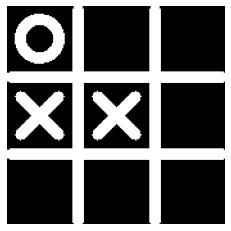


Action values: 23=>-0.000; 32=>-0.999; 33=>-0.999; 12=>-0.999; 31=>-0.999; 13=>-0.999
q-player-2's move: 23


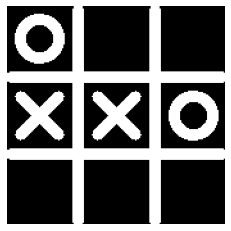


Action values: 33=>-0.000; 31=>-0.997; 12=>0.000; 32=>0.000; 13=>0.000
q-player-1's move: 12


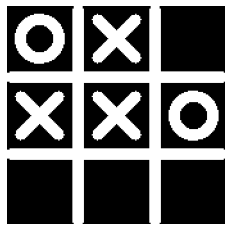


Action values: 32=>-0.000; 33=>-0.999; 31=>-0.999; 13=>-0.999
q-player-2's move: 32


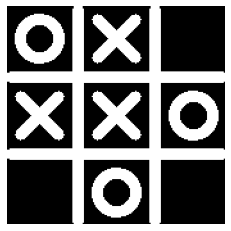


Action values: 31=>0.000; 13=>0.000; 33=>0.000
q-player-1's move: 13


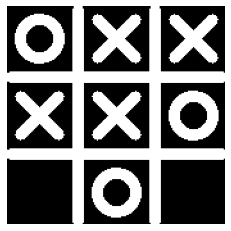


Action values: 33=>-0.999; 31=>0.000
q-player-2's move: 31


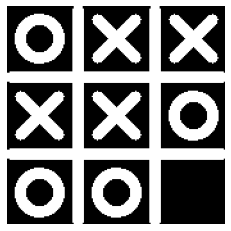


Action values: 33=>0.000
q-player-1's move: 33


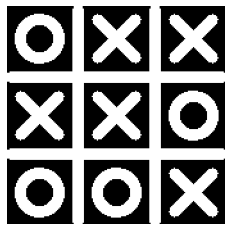

Draw!


In [52]:
player_vs_player(q_player_1, q_player_2)

### Simulating 100000 games

In [54]:
from tqdm import trange

num_games = 100000
results = {0:0,1:0,-1:0}

for _ in trange(num_games):
    game = Game(q_player_1,q_player_2)
    for _ in game.play():
        pass
    results[game.result] += 1

print('Results:')
print(f'Player 1 wins: {results[1]/num_games:.3%}')
print(f'Player 2 wins: {results[-1]/num_games:.3%}')
print(f'Draws: {results[0]/num_games:.3%}')




100%|██████████| 100000/100000 [00:12<00:00, 8318.65it/s]


Results:
Player 1 wins: 0.000%
Player 2 wins: 0.000%
Draws: 100.000%


We see that all of the games lead to draws.

# Games between perfect QPalyer and imperfect QPlayer

A perfect player will sometimes win against an imperfect player. We set the epsilon of one of the players ton non-zero value, so that he makes mistakes.

### The players

In [69]:
q_player_1.epsilon = 0.3
q_player_2.epsilon = 0.


### Visualizing the game

Game Starts!!


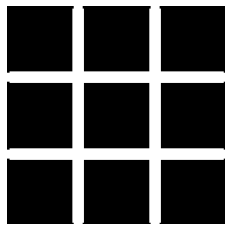


Action values: 12=>0.000; 33=>0.000; 11=>0.000; 32=>0.000; 23=>0.000; 21=>0.000; 13=>0.000; 22=>0.000; 31=>0.000
q-player-1's move: 22


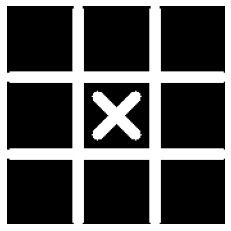


Action values: 31=>-0.000; 11=>-0.000; 13=>-0.000; 33=>-0.000; 32=>-0.995; 12=>-0.995; 21=>-0.995; 23=>-0.995
q-player-2's move: 11


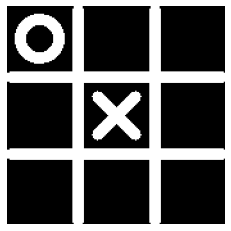


Action values: 32=>-0.000; 21=>0.000; 31=>0.000; 23=>0.000; 12=>0.000; 13=>0.000; 33=>0.000
q-player-1's move: 21


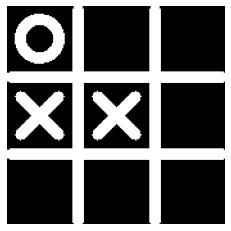


Action values: 23=>-0.000; 32=>-0.999; 33=>-0.999; 12=>-0.999; 31=>-0.999; 13=>-0.999
q-player-2's move: 23


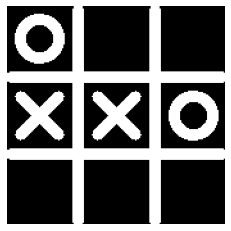


Action values: 33=>-0.000; 31=>-0.997; 12=>0.000; 32=>0.000; 13=>0.000
q-player-1's move: 31


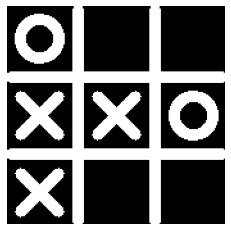


Action values: 12=>-0.999; 33=>-0.999; 32=>-0.999; 13=>0.998
q-player-2's move: 13


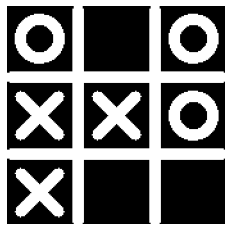


Action values: 33=>-0.999; 12=>-0.999; 32=>-0.999
q-player-1's move: 12


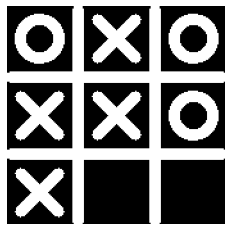


Action values: 32=>0.000; 33=>1.000
q-player-2's move: 33


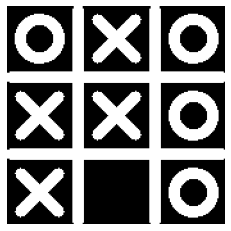

q-player-2 wins!


In [72]:
player_vs_player(q_player_1, q_player_2)

We see that player 1 makes a mistake in his third move that allows player 2 (the perfect player) to win the game.

### Simulating 100000 games

In [73]:
from tqdm import trange

num_games = 100000
results = {0:0,1:0,-1:0}

for _ in trange(num_games):
    game = Game(q_player_1,q_player_2)
    for _ in game.play():
        pass
    results[game.result] += 1

print('Results:')
print(f'Player 1 wins: {results[1]/num_games:.3%}')
print(f'Player 2 wins: {results[-1]/num_games:.3%}')
print(f'Draws: {results[0]/num_games:.3%}')




100%|██████████| 100000/100000 [00:11<00:00, 9064.98it/s]

Results:
Player 1 wins: 0.012%
Player 2 wins: 19.651%
Draws: 80.337%


We see that an epsilon value of 0.3 allows the perfect player 2 to win 20% of the games.